# Talktorial 1

# Compound data acquisition (ChEMBL)

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Paula Junge, Svetlana Leng, Dominique Sydow

## Aim of this talktorial

We learn how to extract data from ChEMBL:

* Find ligands which were tested on a certain target
* Filter available bioactivity data
* Calculate pIC50 values
* Merge `DataFrame`s and draw extracted molecules

## Learning goals


### Theory

* ChEMBL database
    * ChEMBL web services
    * ChEMBL webresource client
* Compound activity measures
    * IC50
    * pIC50

### Practical
    
Goal: Get list of compounds with bioactivity data for a given target

* Connect to ChEMBL database
* Get target data (EGFR kinase)
* Get bioactivity data
    * Download and filter bioactivities
* Get compound data
    * Download and filter compounds
* Merge bioactivity and compound data
    * Draw molecules with highest pIC50
    * Write output file

## References

* ChEMBL bioactivity database (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5210557/)
* ChEMBL web services: <i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620 (https://academic.oup.com/nar/article/43/W1/W612/2467881) 
* ChEMBL webrescource client GitHub (https://github.com/chembl/chembl_webresource_client)
* myChEMBL webservices version 2.x (https://github.com/chembl/mychembl/blob/master/ipython_notebooks/09_myChEMBL_web_services.ipynb)
* ChEMBL web-interface (https://www.ebi.ac.uk/chembl/)
* EBI-RDF platform (https://www.ncbi.nlm.nih.gov/pubmed/24413672)
* IC50 and pIC50 (https://en.wikipedia.org/wiki/IC50)
* UniProt website (https://www.uniprot.org/)

## Theory

### ChEMBL database

* Open large-scale bioactivity database
* **Current data content (as of 10.2018):**
    * \>1.8 million distinct compound structures
    * \>15 million activity values from 1 million assays
    * Assays are mapped to ∼12 000 targets
* **Data sources** include scientific literature, PubChem bioassays, Drugs for Neglected Diseases Initiative (DNDi), BindingDB database, ...
* ChEMBL data can be accessed via a [web-interface](https://www.ebi.ac.uk/chembl/), the [EBI-RDF platform](https://www.ncbi.nlm.nih.gov/pubmed/24413672) and the [ChEMBL web services](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/#B5)

#### ChEMBL web services

* RESTful web service
* ChEMBL web service version 2.x resource schema: 

[![ChEMBL web service schema](images/chembl_webservices_schema_diagram.jpg)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/figure/F2/)

*Figure 1:* 
"ChEMBL web service schema diagram. The oval shapes represent ChEMBL web service resources and the line between two resources indicates that they share a common attribute. The arrow direction shows where the primary information about a resource type can be found. A dashed line indicates the relationship between two resources behaves differently. For example, the `Image` resource provides a graphical based representation of a `Molecule`."
Figure and description taken from: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881).

#### ChEMBL webresource client

* Python client library for accessing ChEMBL data
* Handles interaction with the HTTPS protocol
* Lazy evaluation of results -> reduced number of network requests

### Compound activity measures

#### IC50 

* [Half maximal inhibitory concentration](https://en.wikipedia.org/wiki/IC50)
* Indicates how much of a particular drug or other substance is needed to inhibit a given biological process by half

[<img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png" width="450" align="center" >](https://commons.wikimedia.org/wiki/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png)

*Figure 2:* Visual demonstration of how to derive an IC50 value: 
(i) Arrange data with inhibition on vertical axis and log(concentration) on horizontal axis. (ii) Identify maximum and minimum inhibition. (iii) The IC50 is the concentration at which the curve passes through the 50% inhibition level. Figure ["Example IC50 curve demonstrating visually how IC50 is derived"](https://en.wikipedia.org/wiki/IC50#/media/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png) by JesseAlanGordon is licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/).

#### pIC50

* To facilitate the comparison of IC50 values, we define pIC50 values on a logarithmic scale, such that <br />
    $ pIC_{50} = -log_{10}(IC_{50}) $ where $ IC_{50}$ is specified in units of M.
* Higher pIC50 values indicate exponentially greater potency of the drug
* pIC50 is given in terms of molar concentration (mol/L or M) <br />
    * IC50 should be specified in M to convert to pIC50  
    * For nM: $pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $

#### Other activity measures

Besides, IC50 and pIC50, other bioactivity measures are used, such as the equilibrium constant [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) and the half maximal effective concentration  [EC50](https://en.wikipedia.org/wiki/EC50).

## Practical

In the following, we want to download all molecules that have been tested against our target of interest, the EGFR kinase.

### Connect to ChEMBL database

First, the ChEMBL webresource client as well as other python libraries are imported.

In [1]:
import math

from chembl_webresource_client.new_client import new_client
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools

Create resource objects for API access.

In [2]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [3]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Target data

* Get UniProt ID (http://www.uniprot.org/uniprot/P00533) of the target of interest (EGFR kinase) from UniProt website (https://www.uniprot.org/)
* Use UniProt ID to get target information
* Select a different UniProt ID if you are interested in another target

In [4]:
uniprot_id = 'P00533'

#### Fetch target data from ChEMBL

In [5]:
# Get target information from ChEMBL but restrict to specified values only
targets = targets_api.get(
    target_components__accession=uniprot_id
).only(
    'target_chembl_id', 
    'organism', 
    'pref_name', 
    'target_type'
)
print(type(targets))

<class 'chembl_webresource_client.query_set.QuerySet'>


#### Download target data from ChEMBL

The results of the query are stored in `targets`, a `QuerySet`, i.e. the results are not fetched from ChEMBL unitl we ask for it (here using `pandas.DataFrame.from_records`).

More information about the `QuerySet` datatype:

> QuerySets are lazy – the act of creating a QuerySet doesn’t involve any database activity. You can stack filters together all day long, and Django won’t actually run the query until the QuerySet is evaluated. 
From: https://docs.djangoproject.com/en/3.0/topics/db/queries/#querysets-are-lazy

In [6]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN


#### Select target (target ChEMBL ID)

After checking the entries, we select the first entry as our target of interest:

`CHEMBL203`: It is a single protein and represents the human Epidermal growth factor receptor (EGFR, also named erbB1) 

In [7]:
target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

Save selected ChEMBL ID.

In [8]:
chembl_id = target.target_chembl_id
chembl_id

'CHEMBL203'

### Bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Fetch bioactivity data for the target from ChEMBL

In this step, we download and filter the bioactivity data and only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [9]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type='IC50', relation='=', assay_type='B'
).only(
    'activity_id',
    'assay_chembl_id', 
    'assay_description', 
    'assay_type', 
    'molecule_chembl_id', 
    'type', 
    'standard_units',
    'relation', 
    'standard_value',
    'target_chembl_id', 
    'target_organism'
 )

print(f'Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}')
print(f'Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}')

Length and type of bioactivities object: 7177, <class 'chembl_webresource_client.query_set.QuerySet'>
Length and type of first element: 13, <class 'dict'>


In [10]:
bioactivities[0]

{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

You are having difficulties to query bioactivities from ChEMBL? 

<details>
    
<summary>Click here.</summary>
    
If you experience difficulties to query the ChEMBL database, we provide here a file containing the results for the query in the previous cell (11 April 2019). We do this using the Python package pickle which serializes Python objects so they can be saved to a file, and loaded in a program again later on.
Learn more about object serialization on [DataCamp](https://www.datacamp.com/community/tutorials/pickle-python-tutorial).

You can load the "pickled" compounds by running the following code:
  
<code>import pickle</code> 

<code>bioactivities = pickle.load(open("../data/T1/EGFR_compounds_from_chembl_query_20190411.p", "rb"))</code> 

</details>

#### Download bioactivity data from ChEMBL

Again, we download the `QuerySet` in the form of a `pandas` `DataFrame`. **This may take some time.**

In [11]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f'DataFrame shape: {bioactivities_df.shape}')
bioactivities_df.head()

DataFrame shape: (7178, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.3
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.0


Note, that we have columns for `standard_units`/`units` and `standard_values`/`values` - in the following we will use the standardized columns (standardization by ChEMBL). Thus, we drop the other two columns.

If we used the `units` and `values` columns, we would need to convert all values with many different units to nM:

In [12]:
bioactivities_df.units.unique()

array(['uM', 'nM', 'pM', 'M', "10'3 uM", "10'1 ug/ml", 'ug ml-1',
       "10'-1microM", "10'1 uM", "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM",
       "10'-3 ug/ml", "10'-2microM", '/uM', "10'-6g/ml", 'mM', 'umol/L',
       'nmol/L', "10'-10M"], dtype=object)

In [13]:
bioactivities_df.drop(['units', 'value'], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50


#### Freeze bioactivity data to ChEMBL 27

This step is a technicality: Usually, we would continue to work with the dataset that we just downloaded (latest dataset). 

However, here on the TeachOpenCADD platform, we prefer to freeze the dataset to a certain ChEMBL release (i.e. ChEMBL 27: http://doi.org/10.6019/CHEMBL.database.27), 
so that this talktorial and other talktorials downstream in our CADD pipeline do not change in the future (helping us to maintain the talktorials).

Load bioactivity IDs in ChEMBL 27 release from file `data/chembl27_activities.npz`.

If you are interested, you can check out how this file was generated in `data/all_chembl_activities.ipynb`.

In [14]:
with np.load("../data/T1/chembl27_activities.npz") as f:
    bioactivity_ids_chembl_27 = set(f["activities"])
    
print(f'Number of bioactivity values in ChEMBL 27 release: {len(bioactivity_ids_chembl_27)}')

Number of bioactivity values in ChEMBL 27 release: 16066124


Keep only bioactivities with bioactivity IDs from the ChEMBL 27 release.

In [15]:
print(f'Number of bioactivities before ChEMBL 27 filter: {bioactivities_df.shape[0]}')
bioactivities_df = bioactivities_df[bioactivities_df.activity_id.isin(bioactivity_ids_chembl_27)].copy()
print(f'Number of bioactivities after ChEMBL 27 filter: {bioactivities_df.shape[0]}')

Number of bioactivities before ChEMBL 27 filter: 7178
Number of bioactivities after ChEMBL 27 filter: 7178


Note: If these numbers are the same, it means the latest ChEMBL release is still ChEMBL 27. 

You can check out the current ChEMBL release here: https://chembl.gitbook.io/chembl-interface-documentation/downloads

#### Preprocess and filter bioactivity data

1. Convert `standard_value`'s datatype from `object` to `float`.
2. Delete entries with missing values.
3. Keep only entries with `standard_unit == nM`.
4. Delete duplicate molecules.
5. Reset `DataFrame` index.
6. Rename columns.

**1. Convert `standard_value`'s datatype from `object` to `float`.**

The field `standard_value` holds standardized (here IC50) values. In order to make these values useable in calculations lateron, convert values to floats.

In [16]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [17]:
bioactivities_df = bioactivities_df.astype({'standard_value': 'float64'})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values.**

Use the parameter `inplace=True` to drop values in the current `DataFrame` directly.

In [18]:
bioactivities_df.dropna(
    axis=0, 
    how='any', 
    inplace=True
)
print(f'DataFrame shape: {bioactivities_df.shape}')

DataFrame shape: (7177, 11)


**3. Keep only entries with `standard_unit == nM`.**

We only want to keep bioactivity entries in `nM`, thus we remove all entries with other units.

In [19]:
print(f'Units in downloaded data: {bioactivities_df.standard_units.unique()}')
print(f'Number of non-nM entries: {bioactivities_df[bioactivities_df.standard_units != "nM"].shape[0]}')

Units in downloaded data: ['nM' 'ug.mL-1' '/uM']
Number of non-nM entries: 64


In [20]:
bioactivities_df = bioactivities_df[bioactivities_df.standard_units == 'nM']
print(f'Units after filtering: {bioactivities_df.standard_units.unique()}')

Units after filtering: ['nM']


In [21]:
print(f'DataFrame shape: {bioactivities_df.shape}')

DataFrame shape: (7113, 11)


**4. Delete duplicate molecules.**

Sometimes the same molecule (`molecule_chembl_id`) has been tested more than once, in this case, we only keep the first one.

In [22]:
bioactivities_df.drop_duplicates(
    'molecule_chembl_id', 
    keep='first', 
    inplace=True
)
print(f'DataFrame shape: {bioactivities_df.shape}')

DataFrame shape: (5451, 11)


**5. Reset `DataFrame` index.**

Since we deleted some rows, but we want to iterate over the index later, we reset the index to be continuous.

In [23]:
bioactivities_df.reset_index(drop=True, inplace=True) 
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


**6. Rename columns.**

In [24]:
bioactivities_df.rename(
    columns={
        'standard_value': 'IC50', 
        'standard_units': 'units'
    },
    inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


### Compound data

We have a `DataFrame` containing all molecules tested against EGFR (with the respective measured bioactivity). 

Now, we want to get the molecules that are linked to respective bioactivity ChEMBL IDs. 

#### Fetch compound data from ChEMBL

Let's have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [25]:
compounds = compounds_api.filter(
    molecule_chembl_id__in = list(bioactivities_df['molecule_chembl_id'])
).only(
    'molecule_chembl_id',
    'molecule_structures'
)

#### Download compound data from ChEMBL

Again, we download the `QuerySet` in the form of a `pandas` `DataFrame`. **This may take some time.**

In [26]:
compounds_df = pd.DataFrame.from_records(compounds)
print(f'DataFrame shape: {compounds_df.shape}')

DataFrame shape: (5452, 2)


In [27]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
2,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
3,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
4,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...


#### Preprocess and filter compound data

1. Remove entries with missing molecule structure.
2. Delete duplicate molecules.
3. Get molecules with canonical SMILES.

**1. Remove entries with missing molecule structure.**

In [28]:
compounds_df.dropna(
    axis=0, 
    how='any', 
    inplace=True
)
print(f'DataFrame shape: {compounds_df.shape}')

DataFrame shape: (5445, 2)


**2. Delete duplicate molecules.**

In [29]:
compounds_df.drop_duplicates(
    'molecule_chembl_id', 
    keep='first', 
    inplace=True
)
print(f'DataFrame shape: {compounds_df.shape}')

DataFrame shape: (5444, 2)


**3. Get molecules with canonical SMILES.**

So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [30]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [31]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds['molecule_structures']['canonical_smiles'])
    except KeyError:
        canonical_smiles.append(None)
        
compounds_df['smiles'] = canonical_smiles
compounds_df.drop('molecule_structures', axis=1, inplace=True)

Remove all molecules without a canonical SMILES string.

In [32]:
compounds_df.dropna(
    axis=0, 
    how='any', 
    inplace=True
)

### Output (bioactivity-compound) data

#### Summary of compound and bioactivity data

In [33]:
print(f'Bioactivities filtered: {bioactivities_df.shape[0]}')
bioactivities_df.columns

Bioactivities filtered: 5451


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [34]:
print(f'Compounds filtered: {compounds_df.shape[0]}')
compounds_df.columns

Compounds filtered: 5444


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds ChEMBL IDs, keeping the following columns:
* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [35]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[['molecule_chembl_id', 'IC50', 'units']], 
    compounds_df, 
    on='molecule_chembl_id'
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f'Dataset with {output_df.shape[0]} entries.')

Dataset with 5444 entries.


In [36]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [37]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-]
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1


#### Add pIC50 values

As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [38]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [39]:
# Apply conversion to each row of the compounds DataFrame
output_df['pIC50'] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [40]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879


#### Draw compound data

Let's have a look at our collected data set.

In the next steps, we add a column for RDKit molecule objects to our `DataFrame` and look at the structures of the molecules with the highest pIC50 values. 

In [41]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol='smiles')

In [42]:
# Sort molecules by pIC50
output_df.sort_values(
    by="pIC50", 
    ascending=False, 
    inplace=True
)

# Reset index
output_df.reset_index(
    drop=True, 
    inplace=True
)

Show the most active molecules, i.e. molecules with the highest pIC50 values.

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL63786,0.003,nM,11.522879,
1,CHEMBL35820,0.006,nM,11.221849,
2,CHEMBL53711,0.006,nM,11.221849,
3,CHEMBL53753,0.008,nM,11.096910,
4,CHEMBL66031,0.008,nM,11.096910,

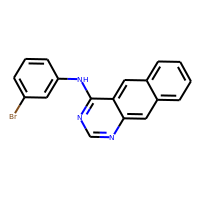
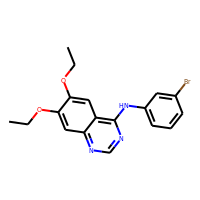
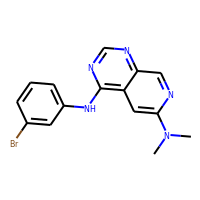
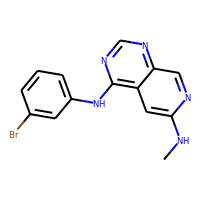
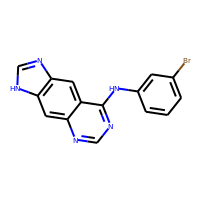

In [43]:
output_df.drop("smiles", axis=1).head()

#### Write output data to file

We want to use this bioactivity-compound dataset in the following talktorials, thus we save the data as `csv` file. 
Note that it is advisable to drop the molecule column (which only contains an image of the molecules) when saving the data.

In [44]:
output_df.drop("ROMol", axis=1).to_csv("../data/T1/EGFR_compounds.csv")

In [45]:
print(f'DataFrame shape: {output_df.shape}')

DataFrame shape: (5444, 6)


## Discussion

In this tutorial, we collected bioactivity data for our target of interest from the ChEMBL database. 
We filtered the data set in order to only contain molecules with measured IC50 or pIC50 bioactivity values. 

Be aware that ChEMBL data originates from various sources. Compound data has been generated in different labs by different people all over the world. Therefore, we have to be cautious with the predictions we make using this data set. It is always important to consider the source of the data and consistency of data production assays when interpreting the results and determining how much confidence we have in our predictions.

In the next tutorials, we will filter our acquired data by Lipinski's rule of five and by unwanted substructures. Another important step would be to clean the data and remove duplicates. As this is not shown in any of our talktorials (yet), we would like to refer to the  [`standardiser` library](https://github.com/flatkinson/standardiser) or [MolVS](https://molvs.readthedocs.io/en/latest/) as useful tools for this task.

## Quiz

* We have downloaded in this talktorial molecules and bioactivity data from ChEMBL. What else is the ChEMBL database useful for?
* What is the difference between IC50 and EC50?
* What can we use the data extracted from ChEMBL for?